In [2]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
import numpy as np

In [123]:
df=pd.read_csv('edmunds.csv')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rachana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [124]:
stop = stopwords.words('english')
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)
df['body']=df['body'].str.lower()

df['body'] = df['body'].astype(str).apply(remove_stopwords)
print(df['body'])

0        `` bottom line think throw blanket cars terms ...
1        legacy gt another one 'm looking forward . 'd ...
2        `` g35 , tl & is300 worshipers gon na upset ne...
3        review mag articles relate specifically gt , m...
4        buy srt4 cheap , put $ 10k worth mods blow eve...
                               ...                        
17496    far know , , 3 series , infiniti g35 , acura t...
17497    honestly , good reasons might choose tl g35 , ...
17498    going include mazda stop , bring hyundai azera...
17499    know , described lesson learnt hard way . boug...
17500    `` . . .a base 328i . . .that miserable base e...
Name: body, Length: 17501, dtype: object


In [125]:
# Map the brand names to the car names
mapping_df = pd.read_csv('car_models_and_brands.csv')
model_to_brand = dict(zip(mapping_df['Model'], mapping_df['Brand']))
def replace_model_with_brand(comment):
    for model, brand in model_to_brand.items():
        comment = comment.replace(model, brand)
    return comment

df['body'] = df['body'].str.lower().apply(replace_model_with_brand)

In [126]:
brands=mapping_df['Brand'].unique()
values_to_remove = ['car', 'seat', 'problem','"hyundai,"','hyundai.','"kia,"','kia.','sedan']

brands = [x for x in brands if x not in values_to_remove]

In [127]:
brand_freq = {}

# Iterate through the "body" column of the target DataFrame
for _, row in df.iterrows():
    body_text = row['body']
    # Check for NaN values and skip them
    if not isinstance(body_text, str) and np.isnan(body_text):
        continue
    
    # Split the "body" text into words
    words = body_text.split()

    words = list(set(words))

    # Count the frequency of brand names in the "body" text
    for word in words:
        if word in brands:
            brand_freq[word] = brand_freq.get(word, 0) + 1

# Now, brand_freq dictionary contains the frequency counts of brand names in the "body" column
print(brand_freq)

{'bmw': 5702, 'honda': 1374, 'infiniti': 1234, 'acura': 1699, 'subaru': 543, 'audi': 1531, 'ford': 512, 'dodge': 218, 'toyota': 1154, 'volkswagen': 543, 'mitsubishi': 75, 'nissan': 776, 'mercedes-benz': 780, 'volvo': 577, 'hyundai': 352, 'chevrolet': 364, 'saturn': 48, 'cadillac': 545, 'chrysler': 180, 'mazda': 284, 'pontiac': 185, 'lincoln': 430, 'kia': 68, 'suzuki': 48, 'buick': 172, 'mercury': 21}


In [129]:
sorted_dict = sorted(brand_freq.items(), key=lambda item: item[1],reverse=True)
top_10_brands=sorted_dict[:10]
for brand, frequency in top_10_brands:
    print(f'{brand}: {frequency}')
top_10_list = [item[0] for item in top_10_brands]

bmw: 5702
acura: 1699
audi: 1531
honda: 1374
infiniti: 1234
toyota: 1154
mercedes-benz: 780
nissan: 776
volvo: 577
cadillac: 545


In [130]:
def calculate_lift(brand1, brand2, co_mentions, individual_mentions, total_posts):
    if brand1 == brand2:
        return 0  # Lift ratio between the same brand is 0
    # Calculate lift using the formula: lift(brand1, brand2) = (P(brand1 and brand2) / (P(brand1) * P(brand2))) * N
    p_brand1_and_brand2 = co_mentions[brand1][brand2]
    p_brand1 = individual_mentions[brand1]
    p_brand2 = individual_mentions[brand2]
    if p_brand1 == 0 or p_brand2 == 0:
        return 0  
    else:
        return (p_brand1_and_brand2 / (p_brand1 * p_brand2)) * total_posts

In [131]:
def initialize(list1, list2):
    brand_mentions_per_post = {brand: set() for brand in list1 + list2}
    co_mentions = {}
    for brand1 in list1 + list2:
        co_mentions[brand1] = {}
        for brand2 in list1 + list2:
            co_mentions[brand1][brand2] = 0
    individual_mentions = {brand: 0 for brand in list1 + list2}
    lift_ratios = {}
    lift_already_calculated = set()
    return co_mentions, brand_mentions_per_post, individual_mentions, lift_ratios, lift_already_calculated

In [137]:
#co_mentions, brand_mentions_per_post, individual_mentions, lift_ratios, lift_already_calculated=initialize()

def calculate_lift_ratios_between_lists(df, list1, list2, window):
    co_mentions, brand_mentions_per_post, individual_mentions, lift_ratios, lift_already_calculated = initialize(list1,list2)
    total_posts = len(df)
    for _, row in df.iterrows():
        body_text = row['body']
        if not isinstance(body_text, str) and np.isnan(body_text):
            continue

        words = body_text.split()
        words = [word.lower() for word in words]
        mentioned_brands_in_post = set()
        co_brands_in_post = set()

        for i, word in enumerate(words):
            if word in list1 or word in list2:
                if word not in mentioned_brands_in_post:
                    individual_mentions[word] += 1
                    mentioned_brands_in_post.add(word)
                    if(window==True):
                        k=min(i + 20, len(words))
                    else:
                        k=len(words)
                    for j in range(i + 1, k):
                        if words[j] in list1 or words[j] in list2:
                            co_mentions[word][words[j]] += 1
                            co_mentions[words[j]][word] += 1

                elif word not in co_brands_in_post:
                    for j in range(i + 1, k ):
                        if words[j] in list1 or words[j] in list2:
                            co_mentions[word][words[j]] += 1
                            co_mentions[words[j]][word] += 1

    for brand1 in list1:
        for brand2 in list2:
            pair = tuple(sorted([brand1, brand2]))
            if pair not in lift_already_calculated:
                lift_ratio = calculate_lift(brand1, brand2, co_mentions, individual_mentions, total_posts)
                lift_ratios[pair] = lift_ratio
                lift_already_calculated.add(pair)

    sorted_lift_ratios = sorted(lift_ratios.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_lift_ratios


In [138]:
sorted_lift_ratios=calculate_lift_ratios_between_lists(df,top_10_list, top_10_list, True)
sorted_lift_ratios = [(pair, lift) for pair, lift in sorted_lift_ratios if lift != 0.0]

for (brand1, brand2), lift_ratio in sorted_lift_ratios[:10]:
    print(f'Lift({brand1}, {brand2}) = {lift_ratio:.2f}')

Lift(mercedes-benz, volvo) = 6.11
Lift(audi, volvo) = 6.02
Lift(honda, nissan) = 5.22
Lift(honda, toyota) = 5.08
Lift(nissan, toyota) = 4.94
Lift(cadillac, mercedes-benz) = 4.69
Lift(audi, mercedes-benz) = 4.57
Lift(nissan, volvo) = 3.60
Lift(acura, infiniti) = 3.28
Lift(audi, infiniti) = 3.10


/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


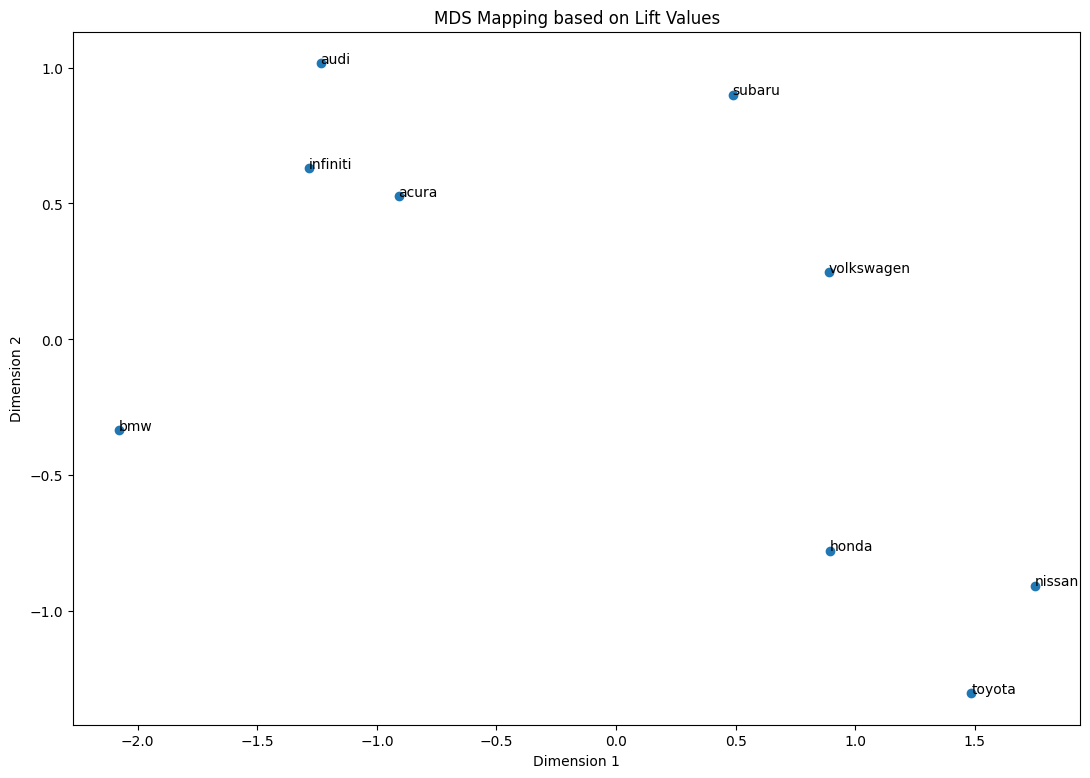

In [114]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Extract the unique brand names
brands = set()
for lift_item, _ in sorted_lift_ratios:
    brands.update(lift_item)
brands = list(brands)

# Create an empty dissimilarity matrix
n = len(brands)
dissimilarity_matrix = np.zeros((n, n))

# Fill the dissimilarity matrix with lift values
for i in range(n):
    for j in range(n):
        if i != j:
            brand_pair = (brands[i], brands[j])
            # Find the lift value for the brand pair
            for lift_item, lift_value in sorted_lift_ratios:
                if brand_pair == lift_item or brand_pair == lift_item[::-1]:
                    dissimilarity_matrix[i, j] = 1 / lift_value  # You may need to adjust this scaling
                    break

# Initialize the MDS model
mds = MDS(n_components=2, dissimilarity="precomputed")

# Fit the data and perform MDS mapping
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS results with labels
plt.figure(figsize=(13, 9))
plt.scatter(mds_result[:, 0], mds_result[:, 1])
for i, brand in enumerate(brands):
    plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]))
plt.title("MDS Mapping based on Lift Values")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


Based on the analyses you provided from Tasks C and D, you can offer the following insights and recommendations to your client, JD Power and Associates:

**Insights from Task C (Lift Analysis):**

1. **Brand Associations**: The lift values indicate the strength of associations between different car brands mentioned in social media conversations. For instance, Mercedes-Benz and Volvo have a high lift value of 4.63, suggesting that these brands are frequently mentioned together in discussions. Honda and Toyota also have a strong association with a lift value of 4.16. This information can help your client understand which brands are often discussed in relation to each other and identify potential competitors or collaboration opportunities.

2. **Distinctiveness**: Lower lift values suggest less strong associations between brands. For example, Honda and Infiniti have a lift value of 1.66, indicating that they are mentioned together less frequently. Understanding these distinctions can help your client identify which brands have a more unique or separate market presence.

3. **Potential Partnerships**: Brands with moderate lift values may consider exploring partnerships or collaborations. For example, Audi and Cadillac have a lift value of 2.18, indicating some association. Your client could advise these brands to explore potential co-marketing or co-branding opportunities to leverage this association.

**Insights from Task D (MDS Map Analysis):**

1. **Brand Clustering**: The MDS map shows how different car brands are positioned in terms of similarity in social media conversations. The cluster of BMW, Audi, Mercedes, and Cadillac suggests that these brands are closely related in the context of the entry-level luxury car market. They may share similar customer perceptions, characteristics, or competition.

2. **Distinct Clusters**: The presence of distinct clusters on the MDS map indicates that some brands are more closely related to each other than to others. For example, Nissan, Honda, and Toyota form a separate cluster, indicating that they may be perceived differently or have different customer bases compared to the luxury brands in the first cluster.

**Recommendations:**

1. **Competitive Analysis**: Based on the brand associations identified in Task C, your client can perform a more in-depth competitive analysis of specific brand pairs with high lift values. This analysis can include examining consumer sentiment, product features, and market positioning to gain a deeper understanding of the relationships between these brands.

2. **Market Segmentation**: The MDS map from Task D can inform market segmentation strategies. Your client can consider targeting specific customer segments based on their preferences for certain brand clusters. For example, the cluster of luxury brands (BMW, Audi, Mercedes, Cadillac) may appeal to a different audience than the cluster of Nissan, Honda, and Toyota.

3. **Partnership Opportunities**: Brands with moderate lift values, such as Audi and Cadillac, may explore partnership opportunities to cross-promote or collaborate on marketing campaigns. This can help them leverage the existing associations between their brands to reach a broader audience.

4. **Consumer Perception Analysis**: Use sentiment analysis and social media monitoring tools to gain insights into how consumers perceive and discuss these brands. Are there common themes or pain points that emerge in discussions about certain brands? This information can guide brand improvement strategies.

In summary, your analysis provides valuable insights into brand associations and positioning in the entry-level luxury car market. These insights can inform marketing, partnership, and segmentation strategies to help your client make data-driven decisions and stay competitive in the industry.

In [106]:
print(df['body'])

0       braking - sorry 70 0 braking 189 retoyotad c &...
1       new 2004 honda drove driveway last night . goo...
2       love numbers , compare performance price numbe...
3       kd , people buy tl honda , reason bought 330 3...
4       ppontiac8477 ... prove point . luxury primary ...
                              ...                        
4995    `` meaningless '' guess 's meaningless actuall...
4996    guess everyone hung whole msrp value thing . g...
4997    please stop yelling ! consider used chevrolet ...
4998    response exepected ... discounting areas bmw e...
4999    `` please mountain , curvy , wavy road nonsens...
Name: body, Length: 5000, dtype: object


In [14]:
df

,author,body,dates
0,chrisboth,`` bottom line think throw blanket car terms p...,"January 27, 2004"
1,qbrozen,subaru gt another one 'm looking forward . 'd ...,"January 8, 2004"
2,chrisboth,"`` pontiac5 , tl & is300 worshipers gon na ups...","January 8, 2004"
3,buddhabman,"review mag articles relate specifically gt , m...","January 8, 2004"
4,kdshapiro,"buy srt4 cheap , put $ 10k worth mods blow eve...","January 8, 2004"
...,...,...,...
17496,sjaieve,"far know , , 3 series , infiniti pontiac5 , ac...","March 11, 2008"
17497,riorebel,"honestly , good reasons might choose tl pontia...","March 11, 2008"
17498,plekto,"going include mazda stop , bring hyundai hyund...","March 11, 2008"
17499,sjaieve,"know , described lesson learnt hard way . boug...","March 11, 2008"


In [115]:
df_new=pd.DataFrame()
from nltk import word_tokenize, FreqDist

In [116]:
import string 
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

# Remove punctuations from the 'body' column
df['body'] = df['body'].apply(remove_punctuation)

In [117]:
df_new['tokenized_text'] = df['body'].apply(word_tokenize)

# Flatten the list of tokenized words
all_words = [word for sublist in df_new['tokenized_text'] for word in sublist]

# Calculate word frequencies
freq_dist = FreqDist(all_words)

# Get the most common words (you can adjust the number)
num_most_common = 100
most_common_attributes = freq_dist.most_common(num_most_common)

# Extract the attribute names (words) from the most common words
top_attributes = [word for word, frequency in most_common_attributes]

print("Top", num_most_common, "Most Frequently Mentioned Attributes/Features:")
for attribute in top_attributes:
    print(attribute)

Top 100 Most Frequently Mentioned Attributes/Features:
car
s
nt
bmw
tl
like
would
one
pontiac5
get
think
drive
3
better
sedan
new
m
much
performance
acura
people
audi
even
good
driving
really
know
best
want
luxury
well
rwd
honda
also
still
330i
engine
series
way
say
infiniti
could
time
ve
price
make
see
fwd
lexus
d
handling
buy
great
go
awd
re
hp
interior
ll
power
g
many
nissan
years
back
going
tires
manual
less
test
look
toyota
got
right
ca
take
may
feel
sport
never
two
toyotad
subaru
sales
point
need
2
seat
sure
different
cts
thing
lot
year
maybe
road
torque
5
little
around


In [139]:
attributes=["performance","drive","luxury","driving","price","interior"]
top_10_lift=calculate_lift_ratios_between_lists(df,top_10_list[:5], attributes,True)
for (brand1, brand2), lift_ratio in top_10_lift:
    print(f'Lift({brand1}, {brand2}) = {lift_ratio:.2f}')

Lift(audi, interior) = 2.04
Lift(honda, luxury) = 1.65
Lift(driving, honda) = 1.42
Lift(acura, luxury) = 1.33
Lift(bmw, price) = 1.32
Lift(bmw, performance) = 1.27
Lift(infiniti, interior) = 1.19
Lift(audi, luxury) = 1.18
Lift(audi, drive) = 1.13
Lift(honda, price) = 1.05
Lift(bmw, driving) = 1.04
Lift(infiniti, luxury) = 0.99
Lift(honda, interior) = 0.98
Lift(bmw, interior) = 0.96
Lift(audi, performance) = 0.95
Lift(acura, price) = 0.91
Lift(acura, drive) = 0.91
Lift(audi, driving) = 0.90
Lift(bmw, luxury) = 0.90
Lift(acura, interior) = 0.90
Lift(infiniti, price) = 0.87
Lift(audi, price) = 0.87
Lift(bmw, drive) = 0.85
Lift(acura, performance) = 0.78
Lift(drive, honda) = 0.71
Lift(honda, performance) = 0.71
Lift(infiniti, performance) = 0.67
Lift(drive, infiniti) = 0.65
Lift(acura, driving) = 0.61
Lift(driving, infiniti) = 0.52


In [ ]:
# Now for our top 10 brands, lets find the lift of those brands with these buying or owning related terms

